# PyLightcurve-torch tutorial - Use with GPyTorch

Gaussian Processes (GPs) have been used at several occasions to model the variability exoplanetary light curves, with e.g. [Gibson et al 2012](https://academic.oup.com/mnras/article/419/3/2683/1070795).

[Gpytorch](https://gpytorch.ai/) is "a highly efficient and modular implementation of GPs, with GPU acceleration" implemented in PyTorch.

It makes the perfect candidate tool for anyone willing to combine Pylightcurve-torch with Gaussian Processes (GPs). <br>
Indeed, GPyTorch allows exact and approximate GPs, Deep GPs, and easy integration of neural nets or other pytorch modules. 

In this notebook, a simple example of exact GP regression is presented, where the transit model is simply included in the mean function.

This example was adapted from [GPytorch Regression tutorial](https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html).

In [1]:
import math
import numpy as np
import torch
import gpytorch
import matplotlib.pylab as plt

from pylightcurve_torch import TransitModule

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['font.size'] = 14

# Toy Light Curve

### Generate data

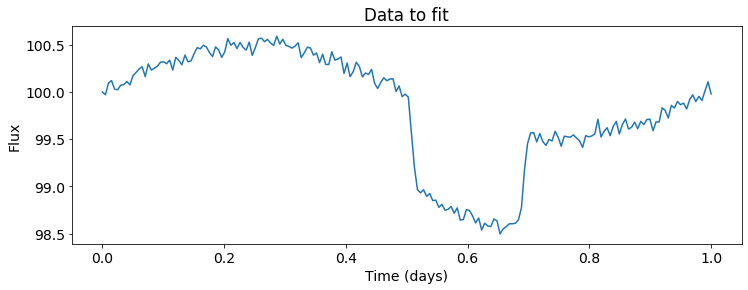

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 200).double().detach()  # Time vector

# Transit model
pars =  {'e':0.01, 'i':90., 'w':0., 'rp': 0.1, 'method': 'linear', 'ldc': [0.1], 
             'P': 4., 't0': 0.6, 'a': 7., 'fp': 0.0001}
tm = TransitModule(train_x, **pars, )

# True function is sin(2*pi*x) with Gaussian noise and transit
train_data = 100. + (torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * np.sqrt(0.01)) / 2
train_data *= tm()[0]

plt.figure(figsize=(12,4))
plt.plot(train_x, train_data.detach())
plt.title('Data to fit')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

# Standardise
mu = train_data.mean()
sigma = train_data.std()

preprocess = lambda y: (y - mu) / sigma
postprocess = lambda y: y * sigma + mu
# preprocess = lambda y: y
train_y = preprocess(train_data)
train_y.double().detach_()
pass

### Define GP model

In [3]:
tm.set_params(**pars)
tm.set_params(rp=0.2, t0=0.55)
tm.activate_grad('rp','t0')   # which transit params to fit

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, tm):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.transit_module = tm 

    def forward(self, x):
        mean_x = (mu + self.mean_module(x)) 
        mean_x *= self.transit_module(time=x.T)[0]  # Careful to the input here, time has to be last dim not first
        mean_x = preprocess(mean_x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().double()
model = ExactGPModel(train_x, train_y, likelihood, tm).double()

In [4]:
training_iter = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': list(model.mean_module.parameters()) 
               + list(model.covar_module.parameters())
               + list(model.likelihood.parameters())},
    {'params': list(model.transit_module.parameters()), 'lr':0.01},  #### different LR for transit par
], lr=0.1)  # Default LR?

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


# Optimise the GP model
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.5f  rp: %.5f  t0: %.5f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        model.transit_module.rp.item(),
        model.transit_module.t0.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 3.231   lengthscale: 0.693   noise: 0.69325  rp: 0.20000  t0: 0.55000
Iter 2/100 - Loss: 2.442   lengthscale: 0.644   noise: 0.74450  rp: 0.19000  t0: 0.56000
Iter 3/100 - Loss: 1.888   lengthscale: 0.600   noise: 0.79549  rp: 0.18020  t0: 0.56993
Iter 4/100 - Loss: 1.514   lengthscale: 0.560   noise: 0.84356  rp: 0.17072  t0: 0.57971
Iter 5/100 - Loss: 1.273   lengthscale: 0.525   noise: 0.88612  rp: 0.16169  t0: 0.58925
Iter 6/100 - Loss: 1.136   lengthscale: 0.496   noise: 0.92129  rp: 0.15318  t0: 0.59835
Iter 7/100 - Loss: 1.079   lengthscale: 0.470   noise: 0.94839  rp: 0.14523  t0: 0.60652
Iter 8/100 - Loss: 1.062   lengthscale: 0.449   noise: 0.96778  rp: 0.13783  t0: 0.61329
Iter 9/100 - Loss: 1.056   lengthscale: 0.432   noise: 0.98025  rp: 0.13098  t0: 0.61859
Iter 10/100 - Loss: 1.051   lengthscale: 0.416   noise: 0.98662  rp: 0.12464  t0: 0.62263
Iter 11/100 - Loss: 1.044   lengthscale: 0.403   noise: 0.98758  rp: 0.11878  t0: 0.62564
Iter 12/100 - Loss:

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x  # in this case test and train data are the same
    observed_pred = likelihood(model(test_x))

/Users/mario/miniconda3/envs/plct-develop/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


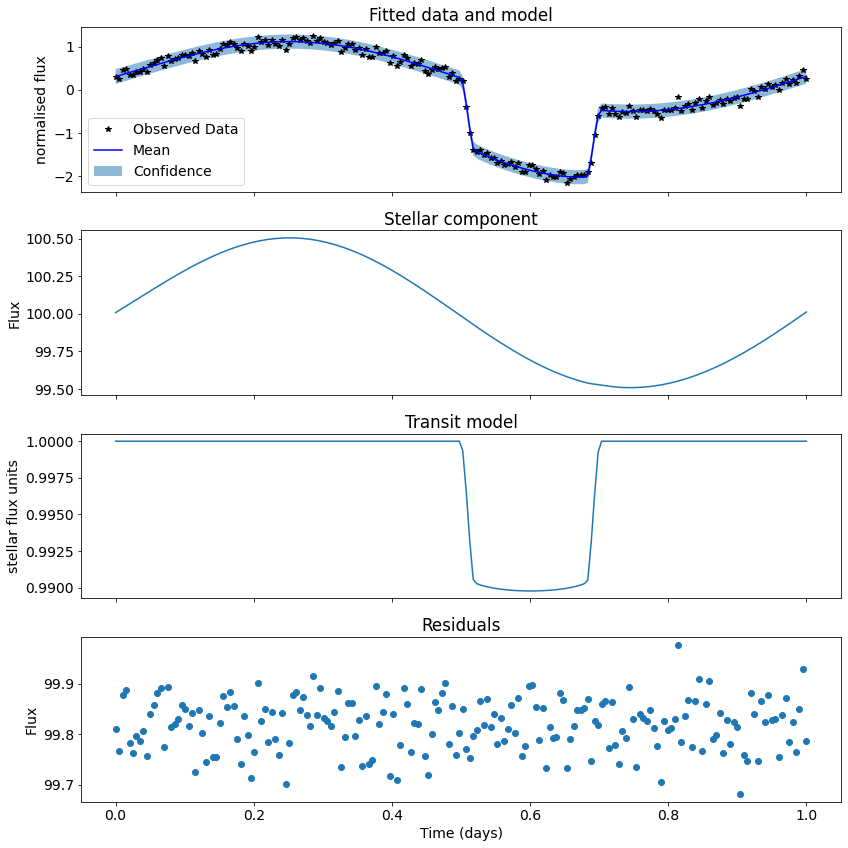

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed Data')
    # Plot predictive means as blue line
#     ax[0].plot(test_x.numpy(), preprocess(postprocess(observed_pred.mean) / model.transit_module(time=test_x)[0]), 'r', label='stellar component of the mean')
    ax[0].plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='Mean')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
    #ax.set_ylim([-3, 3])
    ax[0].set_ylabel('normalised flux')
    ax[0].set_title('Fitted data and model')
    ax[0].legend()
    
    ax[1].plot(test_x.numpy(), postprocess(observed_pred.mean) / model.transit_module(time=test_x)[0])
    ax[1].set_title('Stellar component')
    ax[1].set_ylabel('Flux')

    ax[2].plot(test_x.numpy(), model.transit_module(time=test_x)[0].detach())
    ax[2].set_title('Transit model')
    ax[2].set_ylabel('stellar flux units')
    
    ax[3].scatter(test_x.numpy(), postprocess(train_y - observed_pred.mean))
    ax[3].set_title('Residuals')
    ax[3].set_ylabel('Flux')
    ax[3].set_xlabel('Time (days)')    
plt.tight_layout()